<a href="https://colab.research.google.com/github/darbyna/DATA606_Capstone/blob/main/Cleaned_Data_and_EDA_%7C_DATA606_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#An Investigation of Particulate Matter 2.5 in the DMV area during the COVID-19 Pandemic

### Capstone Project for Data 606

#### Description:


In [2]:
#You can see what GPU you've been assigned at any time by executing the following cell.


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [3]:
#You can see how much memory you have available at any time by running the following code.
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
#Import and install necessary packages:

!pip install -q findspark
!pip install pyspark
!pip install ScalaFunctional 
import os 
import glob
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.regression import LinearRegression
import requests
from bs4 import BeautifulSoup
from functional import seq #ScalaFunctional: Actually works compared to Pyspark.
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import StandardScaler
# Google Drive Save Documents Source: https://stackoverflow.com/questions/53898836/export-dataframe-as-csv-file-from-google-colab-to-google-drive/60733479
from google.colab import drive
drive.mount('drive')

     |████████████████████████████████| 212.4 MB 65 kB/s 
     |████████████████████████████████| 198 kB 78.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=b2b535809b7aefc5b52d9f3eb8fd0458b22f148bb0099b826150030af4a7c630
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark
     |████████████████████████████████| 44 kB 3.4 MB/s 
Mounted at drive


# Import Particulate Matter 2.5 Data: 

In [5]:

PM25_2015 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2015_data_DC_pm25.csv',
   )
PM25_2016 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2016_data_DC_pm25.csv',
   )
PM25_2017 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2017_data_DC_pm25.csv',
   )
PM25_2018 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2018_data_DC_pm25.csv',
   )
PM25_2019 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2019_data_DC_pm25.csv',
   )
PM25_2020 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2020_data_DC_pm25.csv',
   )
DC_PM25_Concentrations = PM25_2015.append(PM25_2016).append(PM25_2017).append(PM25_2018).append(PM25_2019).append(PM25_2020)
DC_PM25_Concentrations


,Date,Source,Site ID,POC,Daily Mean PM2.5 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/03/2015,AQS,110010042,1,18.0,ug/m3 LC,63,HAINS POINT PM-2.5 AND IMPROVE SITE ON ROOF OF...,1,100.0,88502,Acceptable PM2.5 AQI & Speciation Mass,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.876255,-77.034059
1,01/06/2015,AQS,110010042,1,8.9,ug/m3 LC,37,HAINS POINT PM-2.5 AND IMPROVE SITE ON ROOF OF...,1,100.0,88101,PM2.5 - Local Conditions,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.876255,-77.034059
2,01/09/2015,AQS,110010042,1,6.6,ug/m3 LC,28,HAINS POINT PM-2.5 AND IMPROVE SITE ON ROOF OF...,1,100.0,88101,PM2.5 - Local Conditions,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.876255,-77.034059
3,01/12/2015,AQS,110010042,1,12.0,ug/m3 LC,50,HAINS POINT PM-2.5 AND IMPROVE SITE ON ROOF OF...,1,100.0,88101,PM2.5 - Local Conditions,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.876255,-77.034059
4,01/15/2015,AQS,110010042,1,21.6,ug/m3 LC,71,HAINS POINT PM-2.5 AND IMPROVE SITE ON ROOF OF...,1,100.0,88101,PM2.5 - Local Conditions,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.876255,-77.034059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,12/27/2020,AQS,110010053,1,8.2,ug/m3 LC,34,King Greenleaf Rec Center,1,100.0,88101,PM2.5 - Local Conditions,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.875161,-77.012816
1901,12/28/2020,AQS,110010053,1,7.8,ug/m3 LC,33,King Greenleaf Rec Center,1,100.0,88101,PM2.5 - Local Conditions,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.875161,-77.012816
1902,12/29/2020,AQS,110010053,1,4.7,ug/m3 LC,20,King Greenleaf Rec Center,1,100.0,88101,PM2.5 - Local Conditions,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.875161,-77.012816
1903,12/30/2020,AQS,110010053,1,6.2,ug/m3 LC,26,King Greenleaf Rec Center,1,100.0,88101,PM2.5 - Local Conditions,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.875161,-77.012816


# Import Particulate Matter 10 Data:

In [6]:
PM10_2015 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2015_data_DC_pm10.csv',
   )
PM10_2016 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2016_data_DC_pm10.csv',
   )
PM10_2017 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2017_data_DC_pm10.csv',
   )
PM10_2018 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2018_data_DC_pm10.csv',
   )
PM10_2019 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2019_data_DC_pm10.csv',
   )
PM10_2020 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2020_data_DC_pm10.csv',
   )
DC_PM10_Concentrations = PM10_2015.append(PM10_2016).append(PM10_2017).append(PM10_2018).append(PM10_2019).append(PM10_2020)
DC_PM10_Concentrations

,Date,Source,Site ID,POC,Daily Mean PM10 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/01/2015,AQS,110010043,4,12,ug/m3 SC,11,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
1,01/02/2015,AQS,110010043,4,16,ug/m3 SC,15,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
2,01/03/2015,AQS,110010043,4,22,ug/m3 SC,20,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
3,01/04/2015,AQS,110010043,4,5,ug/m3 SC,5,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
4,01/05/2015,AQS,110010043,4,7,ug/m3 SC,6,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,12/27/2020,AQS,110010043,4,16,ug/m3 SC,15,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
336,12/28/2020,AQS,110010043,4,19,ug/m3 SC,18,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
337,12/29/2020,AQS,110010043,4,10,ug/m3 SC,9,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
338,12/30/2020,AQS,110010043,4,14,ug/m3 SC,13,MCMILLAN NCore-PAMS,1,100.0,81102,PM10 Total 0-10um STP,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178


# Import Sulphur Dioxide (SO2) Data:

In [75]:
SO2_2015 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2015_data_DC_so2.csv',
   )
SO2_2016 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2016_data_DC_so2.csv',
   )
SO2_2017 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2017_data_DC_so2.csv',
   )
SO2_2018 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2018_data_DC_so2.csv',
   )
SO2_2019 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2019_data_DC_so2.csv',
   )
SO2_2020 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2020_data_DC_so2.csv',
   )
DC_SO2_Concentrations = SO2_2015.append(SO2_2016).append(SO2_2017).append(SO2_2018).append(SO2_2019).append(SO2_2020)
DC_SO2_Concentrations

,Date,Source,Site ID,POC,Daily Max 1-hour SO2 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/01/2015,AQS,110010043,2,2.6,ppb,3,MCMILLAN NCore-PAMS,24,100.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
1,01/02/2015,AQS,110010043,2,4.7,ppb,6,MCMILLAN NCore-PAMS,24,100.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
2,01/03/2015,AQS,110010043,2,4.5,ppb,6,MCMILLAN NCore-PAMS,24,100.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
3,01/04/2015,AQS,110010043,2,1.3,ppb,1,MCMILLAN NCore-PAMS,24,100.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
4,01/05/2015,AQS,110010043,2,6.1,ppb,9,MCMILLAN NCore-PAMS,23,96.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,12/27/2020,AQS,110010043,2,1.2,ppb,1,MCMILLAN NCore-PAMS,24,100.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
360,12/28/2020,AQS,110010043,2,1.3,ppb,1,MCMILLAN NCore-PAMS,24,100.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
361,12/29/2020,AQS,110010043,2,1.6,ppb,1,MCMILLAN NCore-PAMS,22,92.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
362,12/30/2020,AQS,110010043,2,2.2,ppb,3,MCMILLAN NCore-PAMS,24,100.0,42401,Sulfur dioxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178


# Import Nitrogen Dioxide (NO2) Data:

In [78]:
NO2_2015 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2015_data_DC_no2.csv',
   )
NO2_2016 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2016_data_DC_no2.csv',
   )
NO2_2017 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2017_data_DC_no2.csv',
   )
NO2_2018 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2018_data_DC_no2.csv',
   )
NO2_2019 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2019_data_DC_no2.csv',
   )
NO2_2020 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2020_data_DC_no2.csv',
   )
DC_NO2_Concentrations = NO2_2015.append(NO2_2016).append(NO2_2017).append(NO2_2018).append(NO2_2019).append(NO2_2020)
DC_NO2_Concentrations

,Date,Source,Site ID,POC,Daily Max 1-hour NO2 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/01/2015,AQS,110010043,1,38.7,ppb,36,MCMILLAN NCore-PAMS,24,100.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
1,01/02/2015,AQS,110010043,1,42.3,ppb,40,MCMILLAN NCore-PAMS,24,100.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
2,01/03/2015,AQS,110010043,1,44.2,ppb,42,MCMILLAN NCore-PAMS,24,100.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
3,01/04/2015,AQS,110010043,1,25.0,ppb,24,MCMILLAN NCore-PAMS,24,100.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
4,01/05/2015,AQS,110010043,1,9.5,ppb,8,MCMILLAN NCore-PAMS,24,100.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.921847,-77.013178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,12/27/2020,AQS,110010051,1,29.5,ppb,27,Near Road,20,83.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.894770,-76.953426
1701,12/28/2020,AQS,110010051,1,31.5,ppb,29,Near Road,24,100.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.894770,-76.953426
1702,12/29/2020,AQS,110010051,1,36.5,ppb,34,Near Road,24,100.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.894770,-76.953426
1703,12/30/2020,AQS,110010051,1,34.3,ppb,32,Near Road,22,92.0,42602,Nitrogen dioxide (NO2),47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.894770,-76.953426


# Import Carbon Monoxide (CO) Data:


In [79]:
CO_2015 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2015_data_DC_co.csv',
   )
CO_2016 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2016_data_DC_co.csv',
   )
CO_2017 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2017_data_DC_co.csv',
   )
CO_2018 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2018_data_DC_co.csv',
   )
CO_2019 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2019_data_DC_co.csv',
   )
CO_2020 = pd.read_csv(
  'https://raw.githubusercontent.com/darbyna/DATA606_Capstone/main/606_2020_data_DC_co.csv',
   )
DC_CO_Concentrations = CO_2015.append(CO_2016).append(CO_2017).append(CO_2018).append(CO_2019).append(CO_2020)
DC_CO_Concentrations

,Date,Source,Site ID,POC,Daily Max 8-hour CO Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/01/2015,AQS,110010023,1,0.8,ppm,9,Verizon,19,79.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.903889,-77.046389
1,01/02/2015,AQS,110010023,1,1.1,ppm,13,Verizon,24,100.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.903889,-77.046389
2,01/03/2015,AQS,110010023,1,1.5,ppm,17,Verizon,24,100.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.903889,-77.046389
3,01/04/2015,AQS,110010023,1,0.9,ppm,10,Verizon,24,100.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.903889,-77.046389
4,01/05/2015,AQS,110010023,1,0.6,ppm,7,Verizon,18,75.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.903889,-77.046389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,12/27/2020,AQS,110010051,1,0.7,ppm,8,Near Road,24,100.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.894770,-76.953426
728,12/28/2020,AQS,110010051,1,0.6,ppm,7,Near Road,24,100.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.894770,-76.953426
729,12/29/2020,AQS,110010051,1,0.6,ppm,7,Near Road,24,100.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.894770,-76.953426
730,12/30/2020,AQS,110010051,1,0.8,ppm,9,Near Road,24,100.0,42101,Carbon monoxide,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",11,District Of Columbia,1,District of Columbia,38.894770,-76.953426


# Procure Altitudes

In [7]:
def altitude_extractor(skyline):
    dataset = skyline
    dataset['latlng'] =dataset.apply(lambda x: '{},{}'.format(x['SITE_LATITUDE'], x['SITE_LONGITUDE']), axis=1)
    all_locs = '|'.join(dataset['latlng'].tolist())
    query = 'https://api.opentopodata.org/v1/srtm90m'+f'?locations={all_locs}&interpolation=cubic'
    r = requests.get(query).json()
    dataset['alt'] = pd.json_normalize(r, 'results')['elevation'].values
    dataset.to_csv(r'C:/Users/admin/Desktop/sample.csv')
    data = pd.read_csv(r'C:/Users/admin/Desktop/sample.csv')
    dataset= pd.DataFrame(dataset)
    dataset = dataset.drop(columns=["Unnamed: 0","latlng"])
    print(dataset)

# Import Temperature Data:

In [8]:
#Procure all of the .txt files for analysis:
#Create a groovy function: 
def HTML_URLCounter(html_url):
        #Import the header file
    df_header = pd.read_table(
      'https://raw.githubusercontent.com/darbyna/603Project/master/HEADERS%20(1).csv',
      sep='\s+', 
      engine='python',
      skiprows = 1,
      )
    header_list = list(df_header.columns) 
    #Import the data and visualize the HTML file:
    #Assistance received from: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
    Powerful_Y = requests.get(html_url)
    Powerful_X = BeautifulSoup(Powerful_Y.text, "html.parser")
    The_HTML = Powerful_X.prettify()
    #Now let's get all of the url tags:
    #Assistance received from: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
    #Assistance with ScalaFunctional received from here: https://pypi.org/project/ScalaFunctional/

    All_URL = Powerful_X.findAll('a')
    All_URL


    #Next, create a for loop that will provide us with all of the urls in the HTML file:
    #Assistance with ScalaFunctional received from here: https://pypi.org/project/ScalaFunctional/
    #The seq(url_tags).count(all) is a primary example of ScalaFunctional’s Spark Program counting the images.
    url_tags = []
    for url_link in All_URL:
        url_tags.append(url_link.get('href'))
    return url_tags[5:]

In [13]:
def temperature_compiler(urlx):  
      #Import the header file
  df_header = pd.read_table(
    'https://raw.githubusercontent.com/darbyna/603Project/master/HEADERS%20(1).csv',
    sep='\s+', 
    engine='python',
    skiprows = 1,
    )
  header_list = list(df_header.columns) 
  #Extract URLs of data and port them into data frame:
  spark = SparkSession.builder.appName('606PROJ').getOrCreate()
  sc = SparkContext.getOrCreate(spark)
  list_monger = [] 
  url = HTML_URLCounter(urlx)
  for x in range(0,50,1):
      # In next update, port data using Apache Spark: 
      piper = pd.read_table(
              urlx + url[x],
              sep='\s+', 
              engine='python',
              header = None,
              names = header_list
              )
      
      # In next update, add on column using Apache Spark:
      piper['State'] = url[x][14:16]
      l = len(url[x])
      piper['City'] = url[x][18:l-4]
      piper = spark.createDataFrame(piper).collect()
      #Add Apache Spark DataFrame to the list in next update:
      list_monger = list_monger + [piper]
      # Counter: print(x+1)
  # print(list_monger)
  result = sum(list_monger, [])
  lion = spark.createDataFrame(result)
  # lion.show()
  tiger = lion.toPandas()
  return tiger

In [14]:
Temperature_2015 = temperature_compiler("https://www1.ncdc.noaa.gov/pub/data/uscrn/products/daily01/2015/")
Temperature_2016 = temperature_compiler("https://www1.ncdc.noaa.gov/pub/data/uscrn/products/daily01/2016/")
Temperature_2017 = temperature_compiler("https://www1.ncdc.noaa.gov/pub/data/uscrn/products/daily01/2017/")
Temperature_2018 = temperature_compiler("https://www1.ncdc.noaa.gov/pub/data/uscrn/products/daily01/2018/")
Temperature_2019 = temperature_compiler("https://www1.ncdc.noaa.gov/pub/data/uscrn/products/daily01/2019/")
Temperature_2020 = temperature_compiler("https://www1.ncdc.noaa.gov/pub/data/uscrn/products/daily01/2020/")

In [15]:
SAVE_FILE_NOW = Temperature_2015.append(Temperature_2016).append(Temperature_2017).append(Temperature_2018).append(Temperature_2019).append(Temperature_2020).to_csv('data.csv')
!cp data.csv "drive/My Drive/"

In [16]:
Temperature_Compilation = pd.read_csv('data.csv')
Temperature_Compilation

,Unnamed: 0,"""WBANNO",LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,SOLARAD_DAILY,SUR_TEMP_DAILY_TYPE,SUR_TEMP_DAILY_MAX,SUR_TEMP_DAILY_MIN,SUR_TEMP_DAILY_AVG,RH_DAILY_MAX,RH_DAILY_MIN,RH_DAILY_AVG,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,"SOIL_TEMP_100_DAILY""",State,City
0,0,26565,20150101,2.514,-148.46,70.16,-18.3,-24.4,-21.4,-20.2,0.0,0.00,C,-18.4,-25.3,-21.0,83.3,78.6,81.7,-99.000,-99.000,-99.000,-99.000,-99.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,AK,eadhorse_3_S
1,1,26565,20150102,2.514,-148.46,70.16,-20.9,-25.6,-23.3,-23.8,0.0,0.00,C,-23.2,-26.6,-25.1,87.5,75.5,79.2,-99.000,-99.000,-99.000,-99.000,-99.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,AK,eadhorse_3_S
2,2,26565,20150103,2.514,-148.46,70.16,-23.2,-28.8,-26.0,-26.2,0.0,0.00,C,-25.3,-29.7,-28.0,80.3,72.9,76.2,-99.000,-99.000,-99.000,-99.000,-99.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,AK,eadhorse_3_S
3,3,26565,20150104,2.514,-148.46,70.16,-24.7,-30.5,-27.6,-27.8,0.0,0.00,C,-27.8,-31.3,-29.7,86.9,71.7,75.9,-99.000,-99.000,-99.000,-99.000,-99.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,AK,eadhorse_3_S
4,4,26565,20150105,2.514,-148.46,70.16,-11.5,-28.4,-19.9,-17.8,0.3,0.00,C,-12.0,-29.5,-18.7,93.2,69.1,79.4,-99.000,-99.000,-99.000,-99.000,-99.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,AK,eadhorse_3_S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107953,18295,93243,20201227,2.622,-120.88,37.24,14.8,3.4,9.1,8.2,0.0,9.47,C,19.6,2.8,8.6,95.9,48.6,81.4,0.091,0.091,0.178,0.246,-99.0,9.6,10.6,11.5,12.1,-9999.0,CA,erced_23_WSW
107954,18296,93243,20201228,2.622,-120.88,37.24,13.6,3.3,8.5,7.9,0.8,5.40,C,17.6,2.2,8.1,97.0,60.9,84.5,0.090,0.091,0.178,0.247,-99.0,9.8,10.7,11.5,12.1,-9999.0,CA,erced_23_WSW
107955,18297,93243,20201229,2.622,-120.88,37.24,13.9,-0.8,6.6,5.8,0.0,11.20,C,19.6,-1.0,6.3,98.5,36.8,77.1,0.084,0.092,0.178,0.247,-99.0,7.8,9.8,11.2,12.0,-9999.0,CA,erced_23_WSW
107956,18298,93243,20201230,2.622,-120.88,37.24,13.8,-5.0,4.4,5.0,0.0,9.79,C,18.4,-5.9,5.7,100.0,51.7,81.5,0.082,0.095,0.176,0.244,-99.0,7.2,8.9,10.7,11.7,-9999.0,CA,erced_23_WSW


In [19]:
Temperature_Compilation['State'].unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO'], dtype=object)

# Conduct an Exploratory Data Analysis

#### PM2.5 and PM10 concentrations compared from 2015-2020

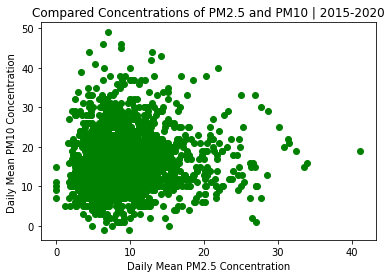

In [106]:
plt.scatter(DC_PM25_Concentrations['Daily Mean PM2.5 Concentration'][:2000], DC_PM10_Concentrations['Daily Mean PM10 Concentration'][:2000], c="green");
plt.title("Compared Concentrations of PM2.5 and PM10 | 2015-2020");
plt.ylabel("Daily Mean PM10 Concentration ");
plt.xlabel("Daily Mean PM2.5 Concentration");

#### PM2.5 and NO2 concentrations compared from 2015-2020


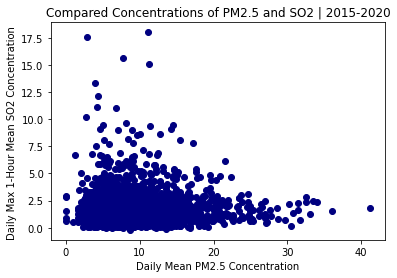

In [108]:
plt.scatter(DC_PM25_Concentrations['Daily Mean PM2.5 Concentration'][:3000], DC_SO2_Concentrations['Daily Max 1-hour SO2 Concentration'][:3000], c="navy");
plt.title("Compared Concentrations of PM2.5 and SO2 | 2015-2020");
plt.ylabel("Daily Max 1-Hour Mean SO2 Concentration ");
plt.xlabel("Daily Mean PM2.5 Concentration");

#### PM2.5 and NO2 concentrations compared from 2015-2020

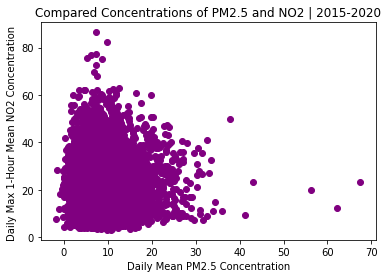

In [109]:
plt.scatter(DC_PM25_Concentrations['Daily Mean PM2.5 Concentration'][:8000], DC_NO2_Concentrations['Daily Max 1-hour NO2 Concentration'][:8000], c="purple");
plt.title("Compared Concentrations of PM2.5 and NO2 | 2015-2020");
plt.ylabel("Daily Max 1-Hour Mean NO2 Concentration ");
plt.xlabel("Daily Mean PM2.5 Concentration");

#### PM2.5 and SO2 concentrations compared from 2015-2020

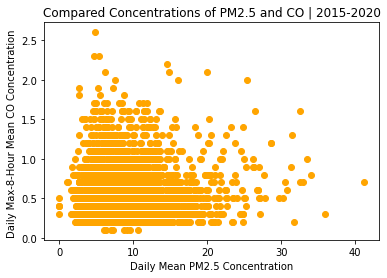

In [110]:
plt.scatter(DC_PM25_Concentrations['Daily Mean PM2.5 Concentration'][:3000], DC_CO_Concentrations['Daily Max 8-hour CO Concentration'][:3000], c="orange");
plt.title("Compared Concentrations of PM2.5 and CO | 2015-2020");
plt.ylabel("Daily Max-8-Hour Mean CO Concentration ");
plt.xlabel("Daily Mean PM2.5 Concentration");

#### DC PM2.5 Concentrations based on the Air Quality index:

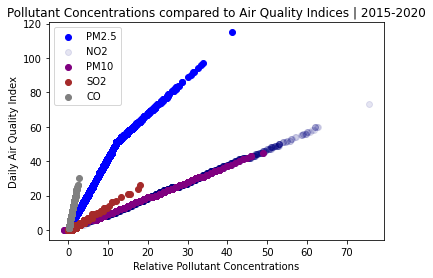

In [140]:
plt.scatter(DC_PM25_Concentrations['Daily Mean PM2.5 Concentration'][:2000], DC_PM25_Concentrations['DAILY_AQI_VALUE'][:2000], c="blue");
plt.scatter(DC_NO2_Concentrations['Daily Max 1-hour NO2 Concentration'][:3000], DC_NO2_Concentrations['DAILY_AQI_VALUE'][:3000], c='navy' ,alpha=0.1);
plt.scatter(DC_PM10_Concentrations['Daily Mean PM10 Concentration'][:2000], DC_PM10_Concentrations['DAILY_AQI_VALUE'][:2000], c='purple');
plt.scatter(DC_SO2_Concentrations['Daily Max 1-hour SO2 Concentration'][:8000], DC_SO2_Concentrations['DAILY_AQI_VALUE'][:8000], c='brown');
plt.scatter(DC_CO_Concentrations['Daily Max 8-hour CO Concentration'][:3000], DC_CO_Concentrations['DAILY_AQI_VALUE'][:3000], c='gray');
plt.legend(['PM2.5', 'NO2', 'PM10','SO2','CO']);
plt.title("Pollutant Concentrations compared to Air Quality Indices | 2015-2020");
plt.xlabel("Relative Pollutant Concentrations");
plt.ylabel("Daily Air Quality Index");

#### Compared length of PM2.5 Data and PM10 Data from 2015-2020:

In [37]:
print("PM2.5 Data Length:", len(DC_PM25_Concentrations),"    ","PM10 Data Length:", len(DC_PM10_Concentrations))

PM2.5 Data Length: 8731      PM10 Data Length: 2085
